In [ ]:
### import libraries
# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
# train test split data and data loader
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
# Calculate R^2 score
from sklearn.metrics import r2_score


import numpy as np
# for dataset management
import pandas as pd
# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats



In [ ]:
data = pd.read_excel('/content/sys_id_ann_train_data.xlsx')
data

,u(k),u(k-1),u(k-2),y(k-1),y(k-2),y(k)
0,0,0,0,0.00,0.00,0.00
1,0,0,0,0.00,0.00,0.00
2,18,0,0,0.00,0.00,0.00
3,18,18,0,0.00,0.00,1.76
4,18,18,18,1.76,0.00,3.36
...,...,...,...,...,...,...
5953,252,251,250,57.04,56.64,57.52
5954,253,252,251,57.52,57.04,57.44
5955,254,253,252,57.44,57.52,58.00
5956,254,254,253,58.00,57.44,58.24


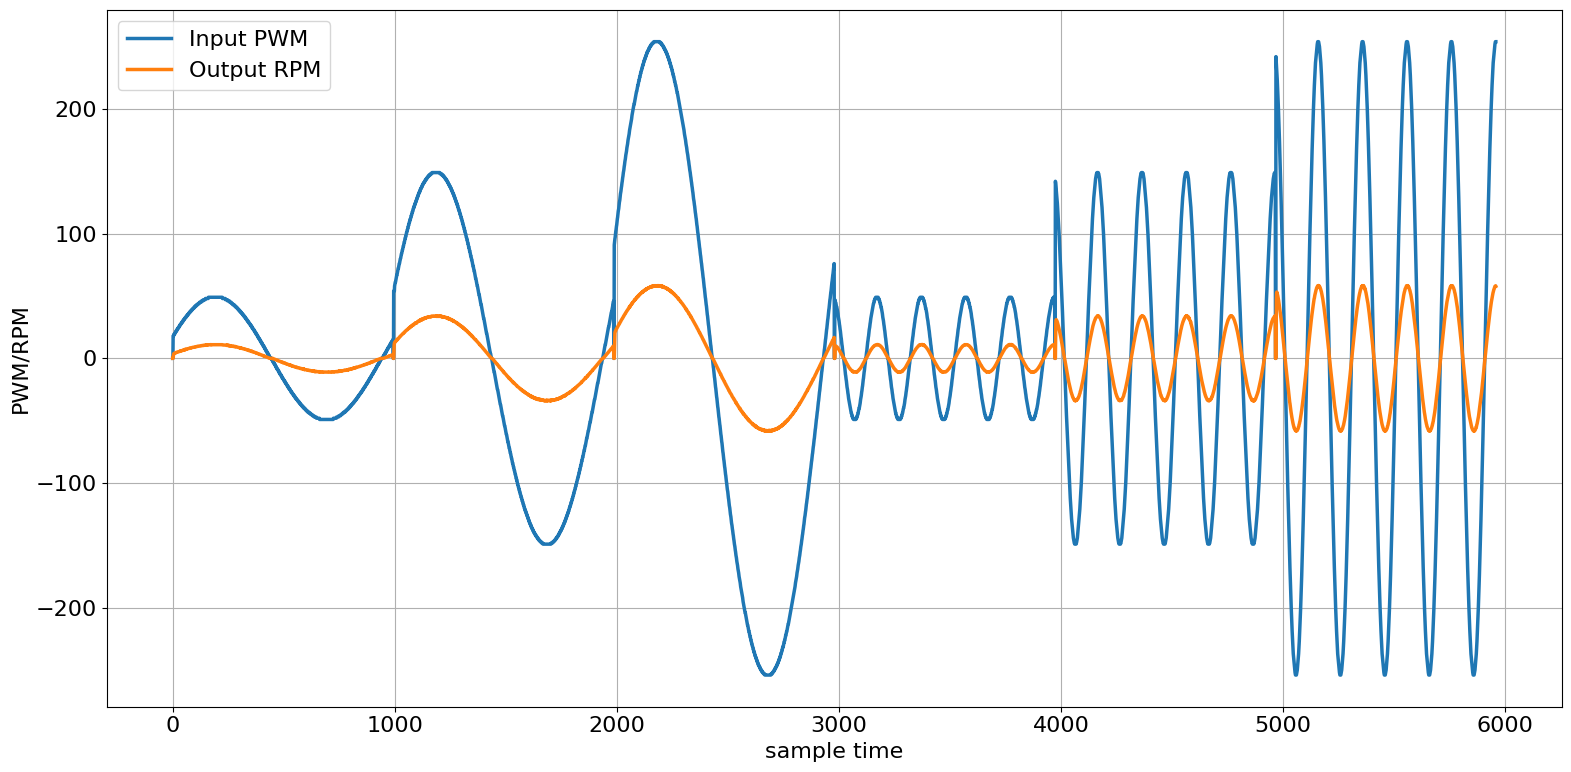

In [ ]:
# Plot the original output (Y) and the output of the ANN
fig = plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 16})
plt.plot(data['u(k)'].values ,label='Input PWM',linewidth=2.5)
plt.plot(data['y(k)'], label='Output RPM',linewidth=2.5)
plt.xlabel('sample time')
plt.ylabel('PWM/RPM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('input_output.png')
plt.show()


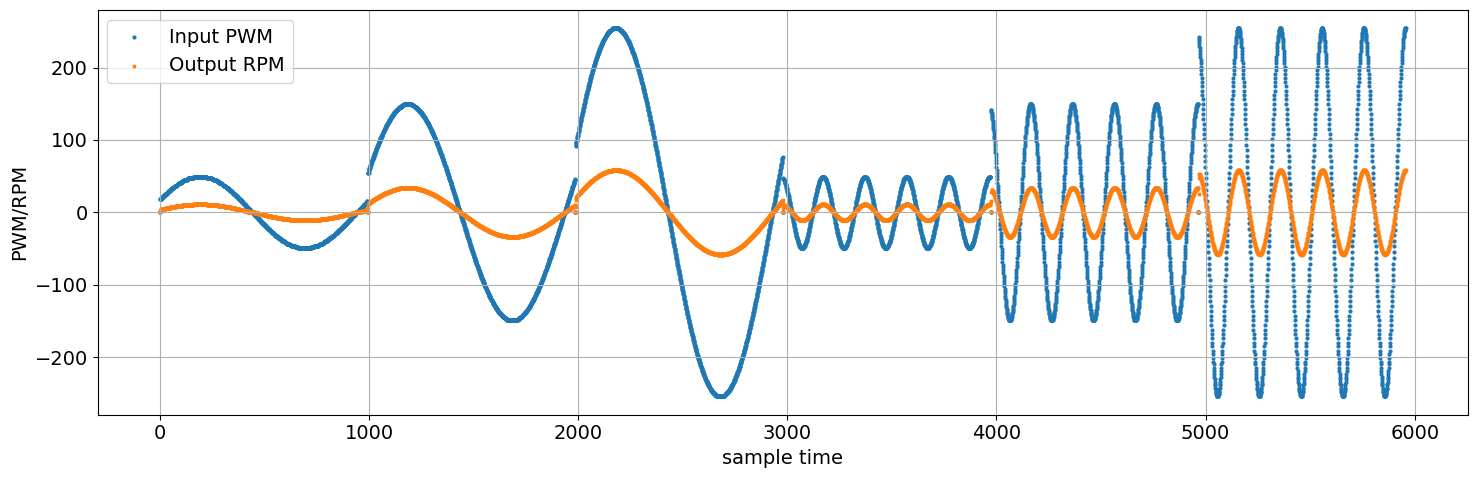

In [ ]:
fig = plt.figure(figsize=(15, 5))

# Plot input PWM as points with reduced marker size
plt.scatter(data.index, data['u(k)'].values, label='Input PWM', marker='o', s=4)

# Plot output RPM as points with reduced marker size
plt.scatter(data.index, data['y(k)'], label='Output RPM', marker='x', s=4)

plt.xlabel('sample time')
plt.ylabel('PWM/RPM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('input_output_scatter_thinner.png')
plt.show()

In [ ]:
data.describe()

,u(k),u(k-1),u(k-2),y(k-1),y(k-2),y(k)
count,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000
mean,-0.901309,-0.943941,-0.986573,-0.250567,-0.260342,-0.240859
std,121.905230,121.860478,121.815695,27.713818,27.703453,27.724035
min,-254.000000,-254.000000,-254.000000,-58.400000,-58.400000,-58.400000
25%,-72.000000,-72.000000,-72.000000,-16.400000,-16.400000,-16.400000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,69.750000,69.000000,15.420000,15.360000,15.440000
max,254.000000,254.000000,254.000000,58.400000,58.400000,58.400000


In [ ]:
#step 1 preparing  data
X= torch.tensor( data[data.keys().drop('y(k)')].values ).float() #input to ANN
Y= torch.tensor( data['y(k)'].values ).float() #output to ANN
# use scikitlearn to split the data
train_x,test_x, train_y,test_y = train_test_split(X, Y, test_size=.1)
# Reshape the target tensor
train_y = train_y.view(-1, 1)
test_y = test_y.view(-1, 1)
# then convert them into PyTorch Datasets
train_data = TensorDataset(train_x,train_y)
test_data  = TensorDataset(test_x,test_y)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check sizes of data batches
for input,output in test_loader:
  print(input.shape,  output.shape)

torch.Size([596, 5]) torch.Size([596, 1])


In [ ]:
#step 2 the ANN structure
class SysIdAnn(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(5,10)

    ### hidden layers
    self.fc1 = nn.Linear(10,10)
    self.fc2 = nn.Linear(10,10)

    ### output layer
    self.output = nn.Linear(10,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

#create object from the class
sys_net = SysIdAnn()
optimizer = torch.optim.Adam(sys_net.parameters(),lr=.001)
lossfun = nn.MSELoss()

In [ ]:
#step 3 the ANN training
# number of training epochs
numepochs = 5
# initialize losses and accuracies
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  batchLoss = []
  for X,Y in train_loader:

    # forward pass and loss
    yHat = sys_net(X)
    loss = lossfun(yHat,Y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this batch
    batchLoss.append(loss.item())

  # end of batch loop...

  # get average losses across the batches
  trainLoss[epochi] = np.mean(batchLoss)

  ## now for the test
  X,Y= next(iter(test_loader))
  yHat = sys_net(X)

  # test loss
  loss = lossfun(yHat,Y)
  testLoss[epochi] = loss.item()


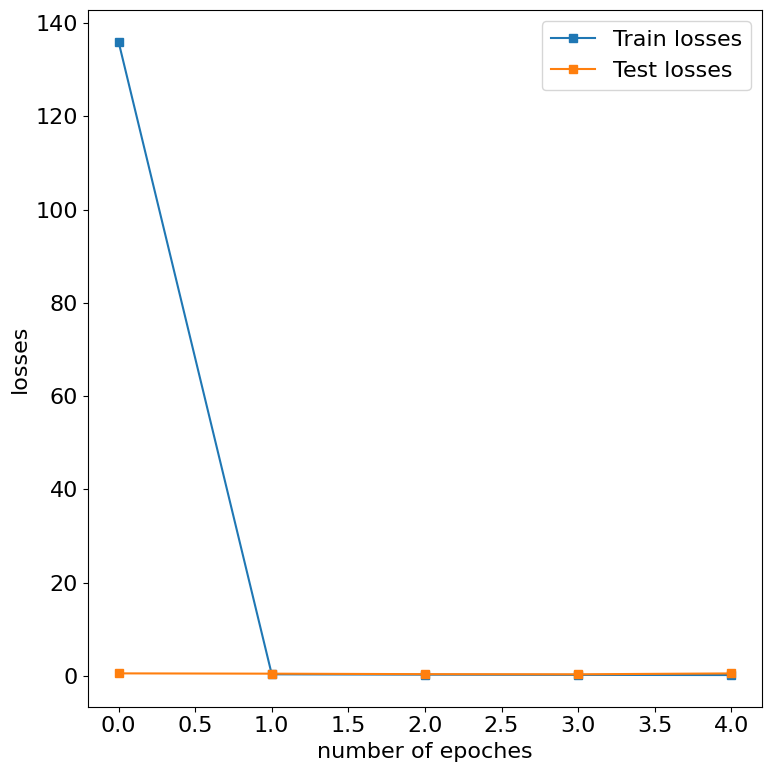

In [ ]:
#plot train losses and test losses
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})

plt.plot(trainLoss,'s-',label='Train losses')
plt.plot(testLoss,'s-',label='Test losses')
plt.xlabel('number of epoches')
plt.ylabel('losses')
plt.legend()
plt.tight_layout()
plt.savefig('train_test_losses.png')


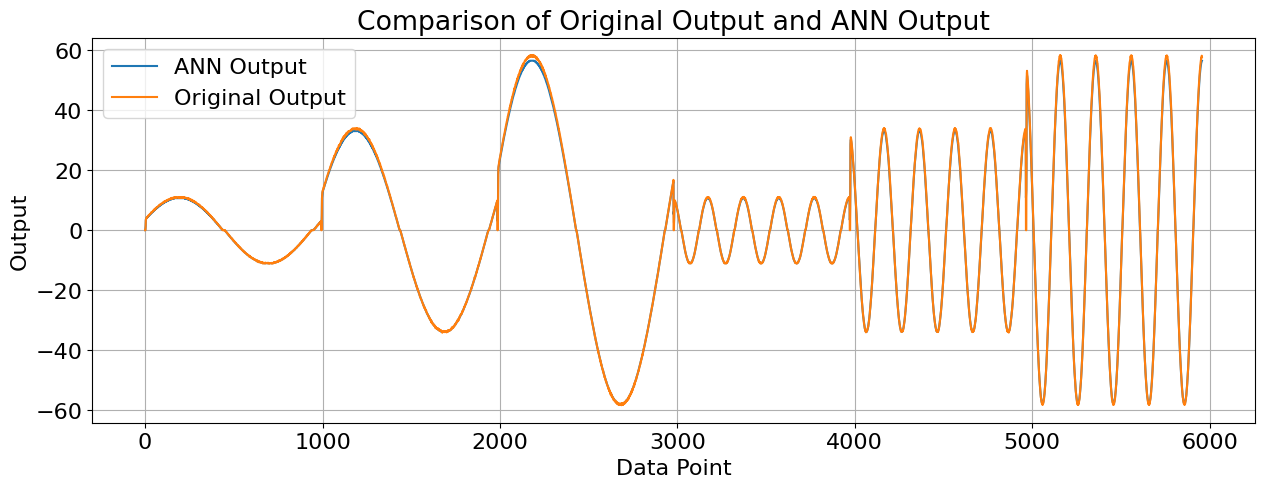

In [ ]:
#plot the real data and predicted data form ANN
X= torch.tensor( data[data.keys().drop('y(k)')].values ).float()
Y= torch.tensor( data['y(k)'].values ).float()
# Forward pass
with torch.no_grad():
    Y_net = sys_net(X)
Y_net = Y_net.numpy()
Y = Y.numpy()
# Plot the original output (Y) and the output of the ANN
fig = plt.figure(figsize=(15, 5))
plt.plot(Y_net ,label='ANN Output')
plt.plot(Y, label='Original Output')
plt.xlabel('Data Point')
plt.ylabel('Output')
plt.title('Comparison of Original Output and ANN Output')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#calculate R^2 score
r_squared = r2_score(Y, Y_net)

# Convert R^2 to percentage
percentage_fit = r_squared * 100

# Display R^2 score and percentage of fit
print("R^2 score:", r_squared)
print("Percentage of fit: {:.2f}%".format(percentage_fit))

R^2 score: 0.9994978362740384
Percentage of fit: 99.95%


In [ ]:
# Save the model state to a file
torch.save(sys_net.state_dict(), 'ann_sys_id_state.pth')

In [ ]:
#validation data
data_valid = pd.read_excel('/content/sys_id_ann_test_data.xlsx')
data_valid

,u(k),u(k-1),u(k-2),y(k-1),y(k-2),y(k)
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,255,0,0,0,0,0
3,255,255,0,0,0,24
4,255,255,255,24,0,48
...,...,...,...,...,...,...
3004,255,255,255,58,58,58
3005,255,255,255,58,58,58
3006,255,255,255,58,58,58
3007,255,255,255,58,58,58


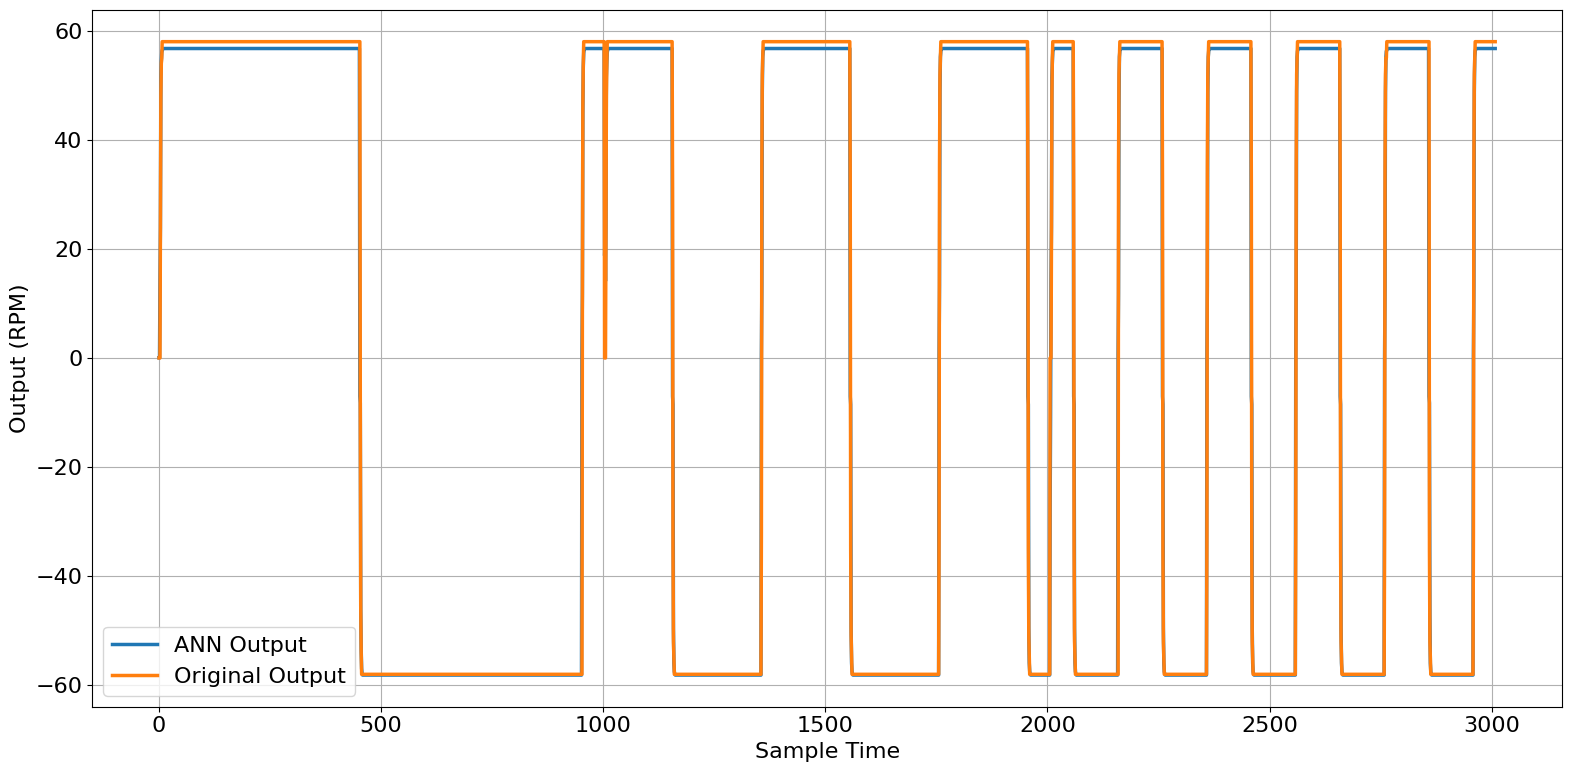

In [ ]:
#validate the model with new data
X= torch.tensor( data_valid [data.keys().drop('y(k)')].values ).float()
Y= torch.tensor( data_valid ['y(k)'].values ).float()
# Forward pass
with torch.no_grad():
    Y_net = sys_net(X)
Y_net = Y_net.numpy()
Y = Y.numpy()
# Plot the original output (Y) and the output of the ANN
fig = plt.figure(figsize=(16, 8))
plt.plot(Y_net ,label='ANN Output',linewidth=2.5)
plt.plot(Y, label='Original Output',linewidth=2.5)
plt.xlabel('Sample Time')
plt.ylabel('Output (RPM)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('validation of model with new data.pdf')

In [ ]:
#calculate R^2 score for validation data
r_squared = r2_score(Y, Y_net)

# Convert R^2 to percentage
percentage_fit = r_squared * 100

# Display R^2 score and percentage of fit
print("R^2 score:", r_squared)
print("Percentage of fit: {:.2f}%".format(percentage_fit))

R^2 score: 0.9953630087780146
Percentage of fit: 99.54%


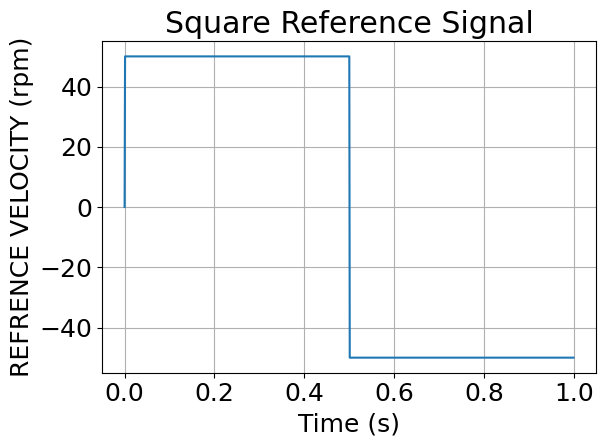

In [ ]:
# Define parameters
duration = 1  # Duration in seconds
sampling_rate = 1000 # Sampling rate in Hz
frequency = 1  # Frequency in Hz
amplitude = 50  # Amplitude of the square wave
# Create time vector
time = np.linspace(0, duration, duration * sampling_rate, endpoint=False)
# Create square wave signal
signal = amplitude * np.sign(np.sin(2 * np.pi * frequency * time))
# Plot the signal
plt.plot(time, signal)
plt.title('Square Reference Signal')
plt.xlabel('Time (s)')
plt.ylabel('REFRENCE VELOCITY (rpm)')
plt.grid(True)
plt.tight_layout()
plt.savefig('refrence signal.pdf')



In [ ]:
#step 2 the ANN structure
class ControlAnn(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(3,10)

    ### hidden layers
    self.fc1 = nn.Linear(10,10)
    self.fc2 = nn.Linear(10,10)
    ### output layer
    self.output = nn.Linear(10,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    # Apply linear transformation
    output = self.output(x)

    # Clip the output to the desired range [-255, 255]
    output = torch.clamp(output, -255, 255)

    return output

con_net = ControlAnn()
optimizer = torch.optim.Adam(con_net.parameters(),lr=.001)
lossfun = nn.MSELoss()

In [ ]:
# initialize losses and accuracies
trainLoss =[]
signals=[]
outputs=[]
r=0 #we have already
e=0
e_1=0
u=0 #calculate from control net
u_1=0
u_2=0
y=0 #calculate from model net
y_1=0
y_2=0
integral=0
derivative=0
# loop over epochs
for i in range(2):
    for t in range(len(signal)):
        r=signal[t]
        e=r-y
        integral+=e
        derivative = e - e_1;
        if integral>255:
            integral=255
        if integral<-255:
            integral=-255
        if r == 0 and round(e) == 0:
            integral = 0

        x_control=torch.tensor([[e,integral,derivative]],dtype=torch.float32)
        # forward pass and loss
        y_control = con_net(x_control)
        u=round(y_control.item())

        # Assuming you have input data 'input_data' as a tensor
        x_model = torch.tensor([[u,u_1,u_2, y_1,y_2]],dtype=torch.float32)

        # Perform forward propagation
        with torch.no_grad():
            y_model = sys_net(x_model)

        y=round(y_model.item())

        y_2=y_1
        y_1=y
        e_1=e

        u_2=u_1
        u_1=u
        y_control.data.fill_(y)
        print(f"r={r} u={u} y={y} e={e}")
        loss = lossfun(torch.tensor([[r]], dtype=torch.float32 ),y_control)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this batch
        trainLoss.append(e)
        signals.append(r)
        outputs.append(y)

r=0.0 u=0 y=0 e=0.0
r=50.0 u=0 y=0 e=50.0
r=50.0 u=0 y=0 e=50.0
r=50.0 u=1 y=0 e=50.0
r=50.0 u=2 y=0 e=50.0
r=50.0 u=3 y=0 e=50.0
r=50.0 u=3 y=0 e=50.0
r=50.0 u=4 y=0 e=50.0
r=50.0 u=4 y=0 e=50.0
r=50.0 u=5 y=1 e=50.0
r=50.0 u=5 y=1 e=49.0
r=50.0 u=6 y=1 e=49.0
r=50.0 u=6 y=1 e=49.0
r=50.0 u=7 y=1 e=49.0
r=50.0 u=7 y=1 e=49.0
r=50.0 u=7 y=1 e=49.0
r=50.0 u=8 y=1 e=49.0
r=50.0 u=8 y=1 e=49.0
r=50.0 u=9 y=2 e=49.0
r=50.0 u=9 y=2 e=48.0
r=50.0 u=10 y=2 e=48.0
r=50.0 u=10 y=2 e=48.0
r=50.0 u=11 y=2 e=48.0
r=50.0 u=11 y=2 e=48.0
r=50.0 u=11 y=2 e=48.0
r=50.0 u=12 y=2 e=48.0
r=50.0 u=12 y=2 e=48.0
r=50.0 u=13 y=2 e=48.0
r=50.0 u=13 y=2 e=48.0
r=50.0 u=14 y=3 e=48.0
r=50.0 u=15 y=3 e=47.0
r=50.0 u=15 y=3 e=47.0
r=50.0 u=16 y=3 e=47.0
r=50.0 u=16 y=3 e=47.0
r=50.0 u=17 y=3 e=47.0
r=50.0 u=17 y=3 e=47.0
r=50.0 u=18 y=4 e=47.0
r=50.0 u=19 y=4 e=46.0
r=50.0 u=19 y=4 e=46.0
r=50.0 u=20 y=4 e=46.0
r=50.0 u=21 y=4 e=46.0
r=50.0 u=21 y=4 e=46.0
r=50.0 u=22 y=4 e=46.0
r=50.0 u=23 y=5 e=46.0
r=50.0 u=2

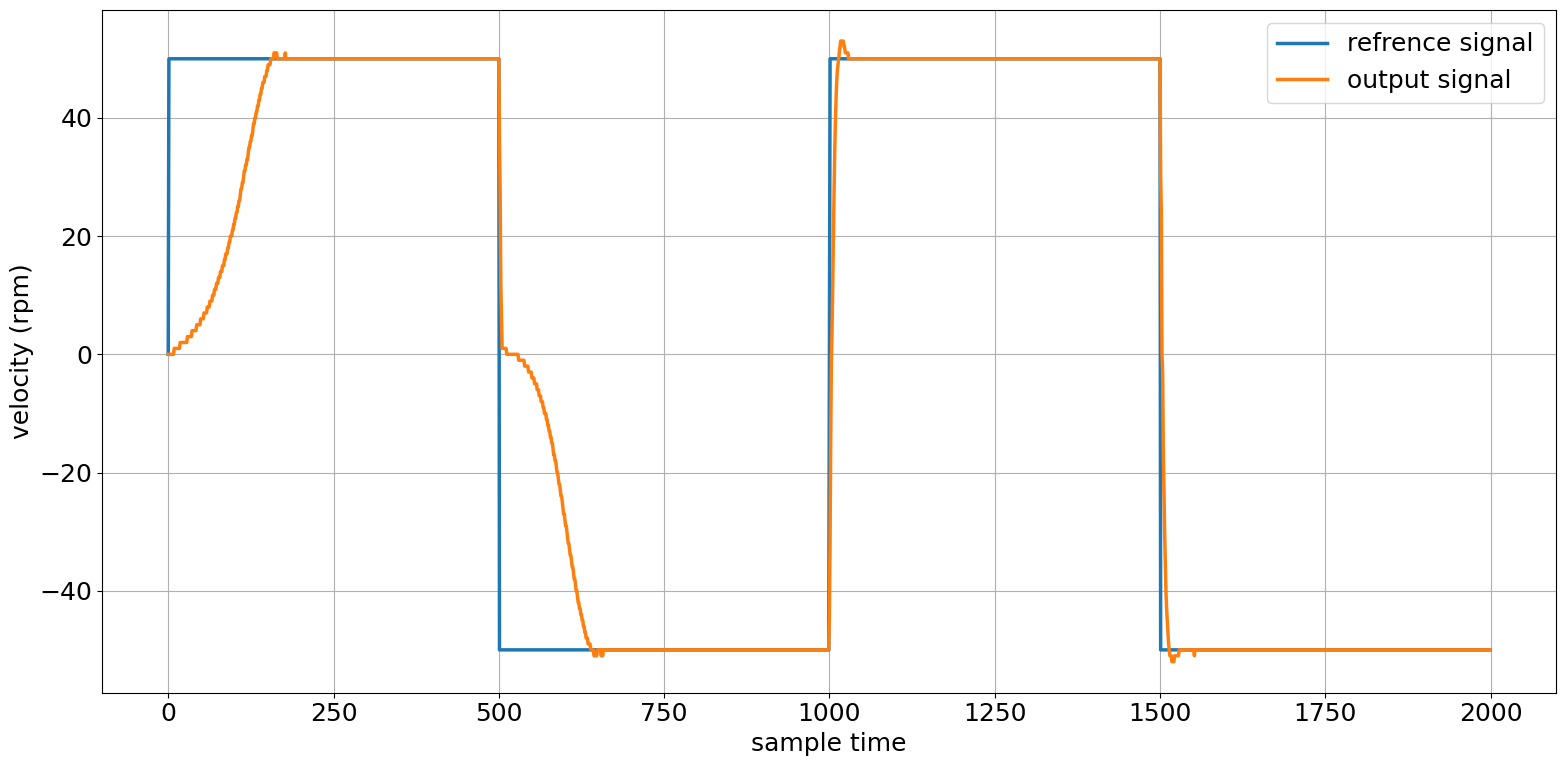

In [ ]:
#plot the refrence signal and ANN output
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 8))
plt.xlabel('sample time')
plt.ylabel('velocity (rpm)')
plt.plot(signals,label="refrence signal",linewidth=2.5)
plt.plot(outputs,label="output signal",linewidth=2.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ann_control_training.png')

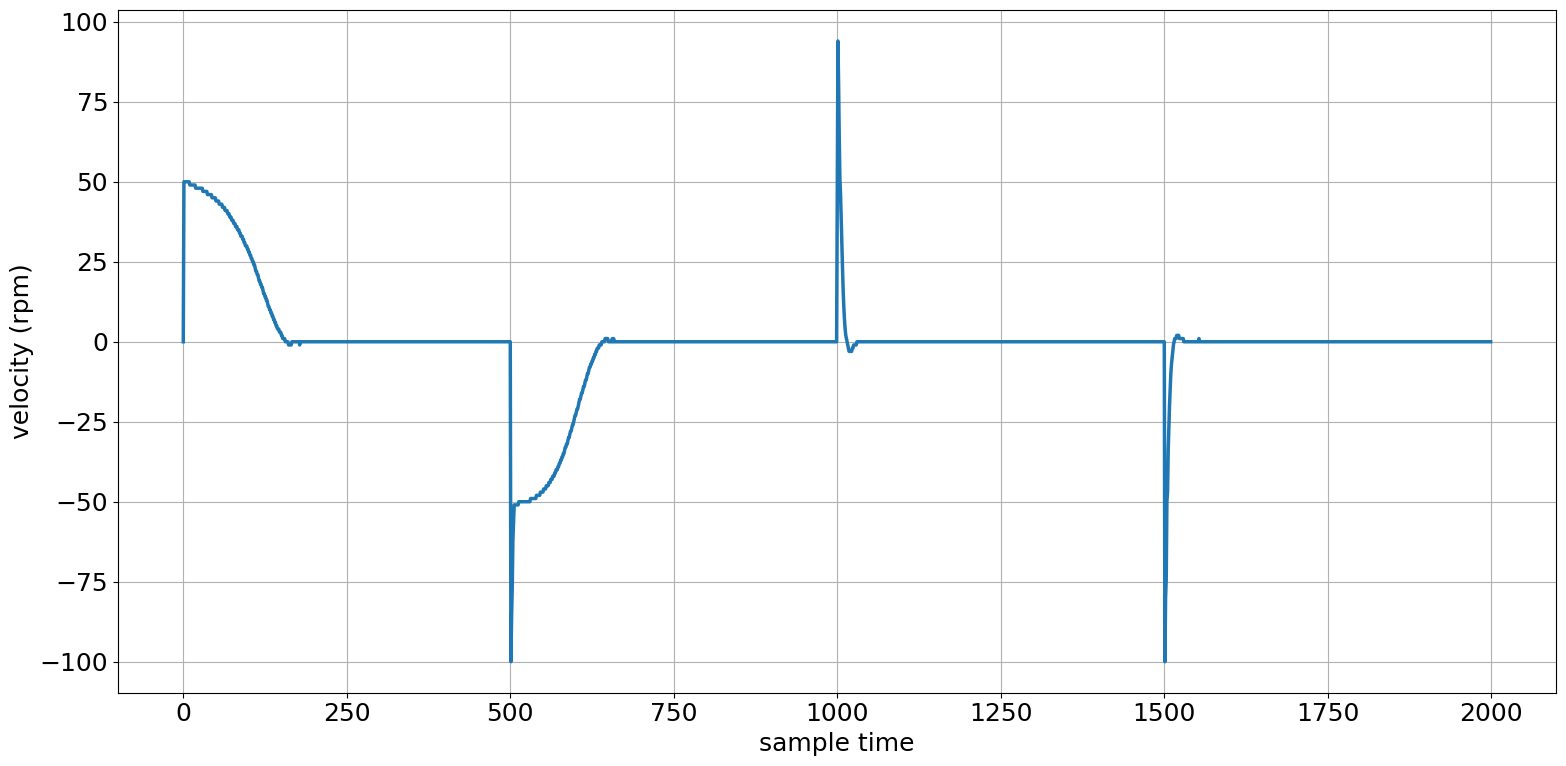

In [ ]:
#plot the error signal
fig = plt.figure(figsize=(16, 8))
plt.plot(trainLoss,linewidth=2.5)

plt.xlabel('sample time')
plt.ylabel('velocity (rpm)')
plt.grid(True)
plt.tight_layout()
plt.savefig('ann_control_losses.png')

In [ ]:
# Save the model state to a file
torch.save(con_net.state_dict(), 'control_ANN.pth')

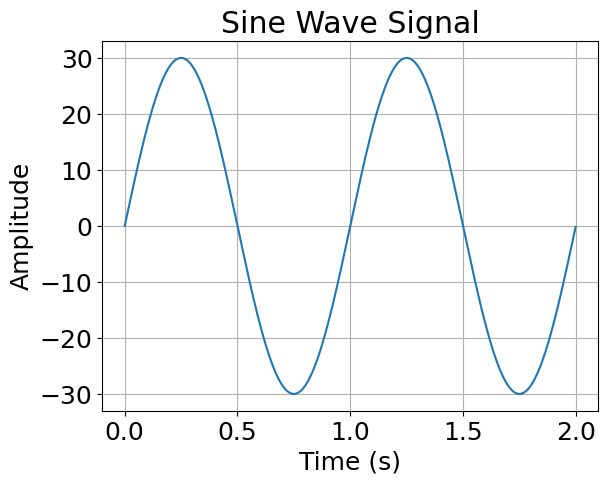

In [ ]:
# Define parameters
frequency = 1  # Frequency of the sine wave in Hz
duration = 2   # Duration of the signal in seconds
sampling_rate = 1000  # Sampling rate in Hz

# Create time vector
time = np.linspace(0, duration, duration * sampling_rate, endpoint=False)

# Generate sine wave signal
signal = 30*np.sin(2 * np.pi * frequency * time)

# Plot the sine wave
plt.plot(time, signal)
plt.title('Sine Wave Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:

# initialize losses and accuracies
e_list=[]
u_list=[]
y_list=[]


r=0 #we have already
e=0
e_1=0
e_2=0
e_3=0
u=0 #calculate from control net
u_1=0
u_2=0
y=0 #calculate from model net
y_1=0
y_2=0

# loop over epochs
for t in range(len(time)):
    r=signal[t]
    e=r-y
    integral+=e
    derivative = e - e_1;
    if integral>255:
        integral=255
    if integral<-255:
        integral=-255
    if r == 0 and round(e) == 0:
        integral = 0
    x_control=torch.tensor([[e,integral,derivative]],dtype=torch.float32)
    with torch.no_grad():
        y_control = con_net(x_control)
    u=round(y_control.item())


    # Assuming you have input data 'input_data' as a tensor
    x_model = torch.tensor([[u,u_1,u_2, y_1,y_2]],dtype=torch.float32)

    # Perform forward propagation
    with torch.no_grad():
        y_model = sys_net(x_model)

    y=y_model.item()

    y_2=y_1
    y_1=y

    e=r-y
    e_3=e_2
    e_2=e_1
    e_1=e

    u_2=u_1
    u_1=u
    #print(f"r={r} u={u} y={y} e={e}")


    # loss from this batch
    e_list.append(e)
    u_list.append(u)
    y_list.append(y)

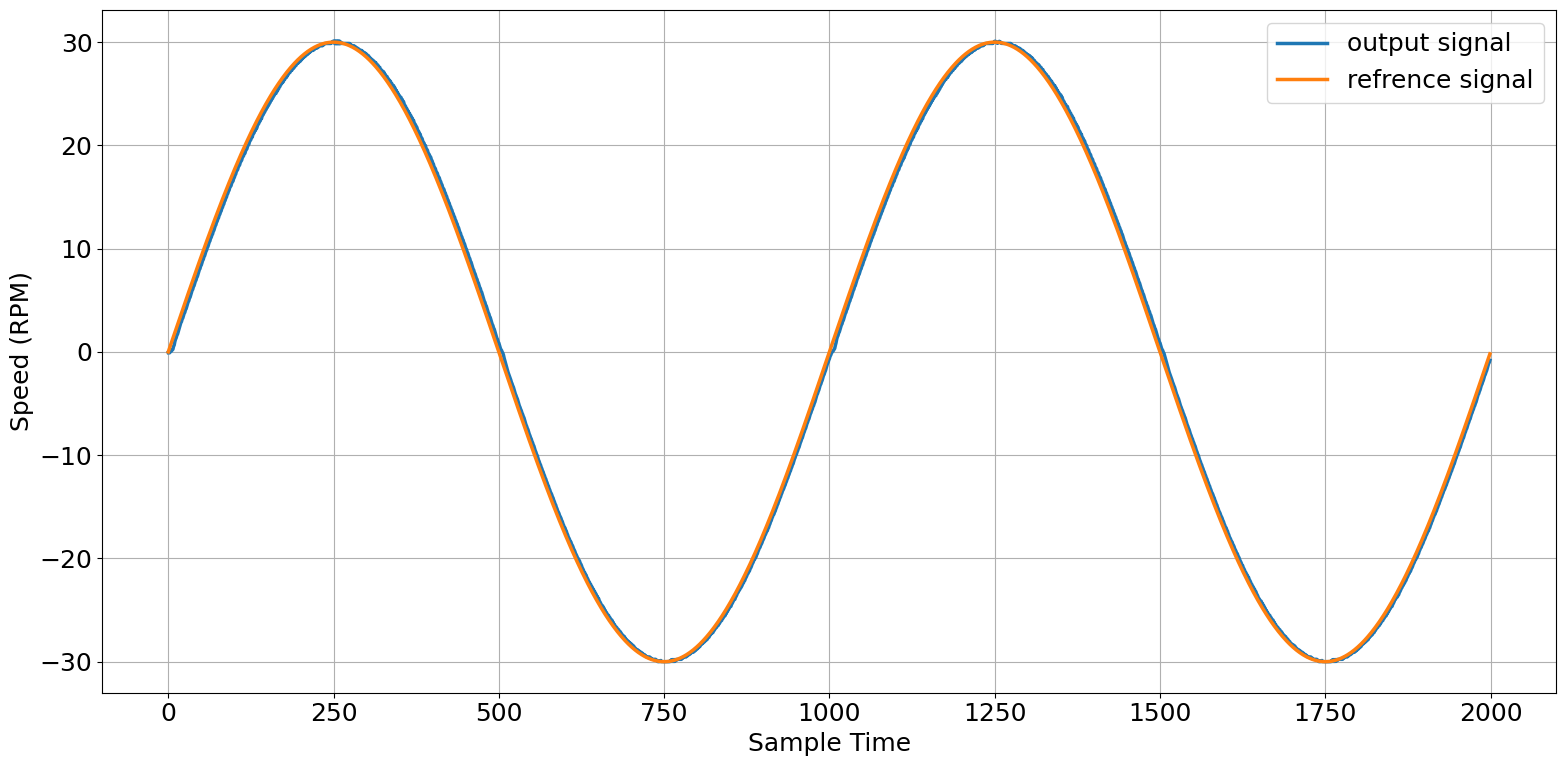

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.plot(y_list,label="output signal",linewidth=2.5)
plt.plot(signal,label="refrence signal",linewidth=2.5)

plt.xlabel('Sample Time')
plt.ylabel('Speed (RPM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('ann_control_square_signal_test.pdf')

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.plot(e_list)
plt.xlabel('Sample Time')
plt.ylabel('Speed (RPM)')
plt.grid(True)
plt.tight_layout()
plt.savefig('ann_control_square_signal_test_error.pdf')

In [ ]:
#calculate R^2 score for validation data
r_squared = r2_score(y_list, signal)

# Convert R^2 to percentage
percentage_fit = r_squared * 100

# Display R^2 score and percentage of fit
print("R^2 score:", r_squared)
print("Percentage of fit: {:.2f}%".format(percentage_fit))

R^2 score: 0.9993394836223601
Percentage of fit: 99.93%
